In [1]:
import pandas as pd
import numpy as np

# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier

# Visualisation libraries

## Text
from colorama import Fore, Back, Style

## seaborn
import seaborn as sns
sns.set_context('paper', rc={'font.size':12,'axes.titlesize':14,'axes.labelsize':12})
sns.set_style('white')

## matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Polygon
import matplotlib.gridspec as gridspec
import matplotlib.colors
from pylab import rcParams
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = 14, 8
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
%matplotlib inline

Spooky Author Identification Dataset Natural Language Processing
============================

# Dataset

In this article, we would like work on a [natural language processing](https://en.wikipedia.org/wiki/Natural_language_processing) (NLP) project. In doing so, we use a dataset from [Kaggle.com](https://www.kaggle.com/c/spooky-author-identification/overview).

<div class="alert alert-block alert-info">
<font size="+2"><b>Spooky Author Identification Dataset</b></font>
</div>


The dataset contains text from works of fiction written by spooky authors of the public domain: Edgar Allan Poe, HP Lovecraft and Mary Shelley. The data was prepared by chunking larger texts into sentences using CoreNLP's MaxEnt sentence tokenizer, so you may notice the odd non-sentence here and there. Your objective is to accurately identify the author of the sentences in the test set.

### File descriptions

* **train.csv** - the training set
* **test.csv** - the test set
* **sample_submission.csv** - a sample submission file in the correct format

### Data fields
* **id** - a unique identifier for each sentence
* **text** - some text written by one of the authors
* **author** - the author of the sentence (EAP: Edgar Allan Poe, HPL: HP Lovecraft; MWS: Mary Wollstonecraft Shelley)

## Loading the Datasets

In [2]:
Data = pd.read_csv('spooky-author-identification/train.csv')
Data.columns = [x.title().replace('Id','ID') for x in Data]
Pred = pd.read_csv('spooky-author-identification/test.csv')
Pred.columns = [x.title().replace('Id','ID') for x in Pred]

def Data_info(Inp, Only_NaN = False):
    Out = Inp.dtypes.to_frame(name='Data Type').sort_values(by=['Data Type'])
    Out = Out.join(Inp.isnull().sum().to_frame(name = 'Number of NaN Values'), how='outer')
    Out['Percentage'] = np.round(100*(Out['Number of NaN Values']/Inp.shape[0]),2)
    if Only_NaN:
        Out = Out.loc[Out['Number of NaN Values']>0]
    return Out

Line = 100*'='
print(Back.BLACK + Fore.GREEN + Style.NORMAL + 'Data Dataset:' +
      Style.RESET_ALL + Fore.BLUE + Style.NORMAL + ' %s' % Line + Style.RESET_ALL)
display(Data.head())
display(Data_info(Data))
print(Back.BLACK + Fore.MAGENTA + Style.NORMAL + 'Pred Dataset:' +
      Style.RESET_ALL + Fore.BLUE + Style.NORMAL + ' %s' % Line + Style.RESET_ALL)
display(Pred.head())
display(Data_info(Pred))
print(Fore.BLUE + Style.NORMAL + '%s' % (Line + Line[:16]) + Style.RESET_ALL)

Data Dataset: ====================================================================================================


,ID,Text,Author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


,Data Type,Number of NaN Values,Percentage
ID,object,0,0.0
Text,object,0,0.0
Author,object,0,0.0


Pred Dataset: ====================================================================================================


,ID,Text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


,Data Type,Number of NaN Values,Percentage
ID,object,0,0.0
Text,object,0,0.0


# Problem Description

The object of the exercise is to recognize/predict the author of a text by creating an NLP model.

# Modeling

First off, let's define  $X$  and  $y$  sets.

## Preprocessing

In this section, we use [**sklearn.preprocessing.LabelEncoder**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) to encode the **author** from the *Data**.

In [3]:
df = Data.copy()
# Encoding
le_author = LabelEncoder()
df['Author'] = le_author.fit_transform(df['Author'].values)

# Map
print(Back.BLACK + Fore.YELLOW + Style.NORMAL + 'Author Map:' + Style.RESET_ALL)
Author_map = {'Author': le_author.classes_, 'Code': df['Author'].unique()}
display(pd.DataFrame(Author_map).style.hide_index())

Author Map:


Author,Code
EAP,0
HPL,1
MWS,2


## Train and Test sets

When it comes to large data and complex algorithms, sampling is a way to test the algorithm parameters before implementing it. This can be done using [**pandas.DataFrame.sample**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html)

In [4]:
# A sample of df dataframe
Temp = df.sample(n = 1000, random_state=1)
X = Temp['Text'].values
y = Temp['Author'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
pd.DataFrame(data={'Set':['X_train','X_test','y_train','y_test'],
               'Shape':[X_train.shape, X_test.shape, y_train.shape, y_test.shape]}).set_index('Set').T

Set,X_train,X_test,y_train,y_test
Shape,"(900,)","(100,)","(900,)","(100,)"


Moreover, we would use [**sklearn.feature_extraction.text.TfidfVectorizer**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to convert **Text** data to a matrix of **TF-IDF features**.

In [5]:
Tfidf_Vec = TfidfVectorizer(min_df=3,  max_features=None,
                             strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                             ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
                             stop_words = 'english')
_ = Tfidf_Vec.fit(list(X))
X_train_TFIDFvec = Tfidf_Vec.transform(X_train) 
X_test_TFIDFvec = Tfidf_Vec.transform(X_test)

## GridSearch Multi-layer Perceptron Classifier

This can be done using [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) and [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [6]:
# Parameters
param_grid = {'solver': ['lbfgs', 'sgd', 'adam'],
              'alpha': [10.0**x for x in np.arange(-1,-4,-1)],
              'learning_rate' : ['constant', 'invscaling', 'adaptive']}

# Multi-layer Perceptron Classifier
mlp = MLPClassifier(max_iter = 1000)

# Searching over specified parameter values for an estimator.
grid_model = GridSearchCV(mlp, param_grid, n_jobs=-1)

# Fitting
_ = grid_model.fit(X_train_TFIDFvec, y_train)

Best Score,Best Paramerers,Accuracy
0.555600,"{'alpha': 0.01, 'learning_rate': 'invscaling', 'solver': 'adam'}",0.630000


rank_test_score,params,mean_test_score
1,"{'alpha': 0.001, 'learning_rate': 'invscaling', 'solver': 'adam'}",0.5556
1,"{'alpha': 0.01, 'learning_rate': 'adaptive', 'solver': 'adam'}",0.5556
1,"{'alpha': 0.01, 'learning_rate': 'invscaling', 'solver': 'adam'}",0.5556
4,"{'alpha': 0.001, 'learning_rate': 'adaptive', 'solver': 'adam'}",0.5544
4,"{'alpha': 0.001, 'learning_rate': 'constant', 'solver': 'adam'}",0.5544
6,"{'alpha': 0.001, 'learning_rate': 'adaptive', 'solver': 'lbfgs'}",0.5522
6,"{'alpha': 0.01, 'learning_rate': 'constant', 'solver': 'adam'}",0.5522
8,"{'alpha': 0.1, 'learning_rate': 'invscaling', 'solver': 'adam'}",0.5500
9,"{'alpha': 0.1, 'learning_rate': 'constant', 'solver': 'adam'}",0.5444
9,"{'alpha': 0.1, 'learning_rate': 'adaptive', 'solver': 'adam'}",0.5444


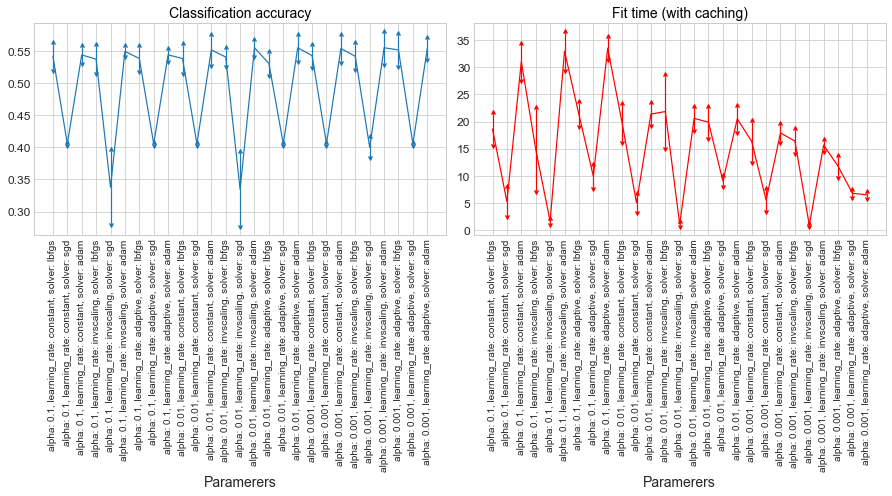

In [7]:
display(pd.DataFrame({'Best Score': [grid_model.best_score_],
                      'Best Paramerers': [str(grid_model.best_params_)],
                      'Accuracy': [grid_model.score(X_test_TFIDFvec,y_test)]}).round(4).style.hide_index())

display(pd.DataFrame(grid_model.cv_results_)[['rank_test_score',
                           'params','mean_test_score']].sort_values(by=['rank_test_score']).style.hide_index()\
        .background_gradient(cmap='YlGn', subset=['mean_test_score']).set_precision(4))

Temp = [str(x) for x in grid_model.cv_results_['params']]
Temp = [s.replace('{', '') for s in Temp]
Temp = [s.replace('}', '') for s in Temp]
Temp = [s.replace("'", '') for s in Temp]

# Plot the results of the grid search.
fig, ax = plt.subplots(1, 2, figsize=(12.5, 7))
# left
_ = ax[0].errorbar(x= Temp,
                   y=grid_model.cv_results_['mean_test_score'],
                   yerr=grid_model.cv_results_['std_test_score'], uplims=True, lolims=True)
_ = ax[0].set(xlabel='Paramerers', title='Classification accuracy')
_ = ax[0].set_xticklabels(labels = Temp, rotation=90, fontsize = 10)
# Right
_ = ax[1].errorbar(x= Temp,
                   y=grid_model.cv_results_['mean_fit_time'],
                   yerr=grid_model.cv_results_['std_fit_time'], color='r', uplims=True, lolims=True)
_ = ax[1].set(xlabel='Paramerers', title='Fit time (with caching)')
_ = ax[1].set_xticklabels(labels = Temp, rotation=90, fontsize = 10)
fig.tight_layout()

Therefore, we can now set up the model using the parameters from GridSearch.

## Train and Test sets

In [8]:
X = df['Text'].values
y = df['Author'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
pd.DataFrame(data={'Set':['X_train','X_test','y_train','y_test'],
               'Shape':[X_train.shape, X_test.shape, y_train.shape, y_test.shape]}).set_index('Set').T

Tfidf_Vec = TfidfVectorizer(min_df=3,  max_features=None,
                             strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                             ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
                             stop_words = 'english')
_ = Tfidf_Vec.fit(list(X))
X_train_TFIDFvec = Tfidf_Vec.transform(X_train) 
X_test_TFIDFvec = Tfidf_Vec.transform(X_test)

In [9]:
# Multi-layer Perceptron classifier
mlp = MLPClassifier(solver = grid_model.best_params_['solver'],
                    alpha = grid_model.best_params_['alpha'],
                    learning_rate = grid_model.best_params_['learning_rate'],
                    max_iter = 1000)
_ = mlp.fit(X_train_TFIDFvec, y_train)

### Classification Report

In [10]:
Labels = Author_map['Author'].tolist()
y_pred = mlp.predict_proba(X_test_TFIDFvec)
Results = pd.DataFrame(classification_report(y_test, y_pred.argmax(axis=1), target_names= Labels, output_dict=True)).T
display(Results.round(2))

,precision,recall,f1-score,support
EAP,0.76,0.78,0.77,777.00
HPL,0.75,0.77,0.76,524.00
MWS,0.80,0.76,0.78,657.00
accuracy,0.77,0.77,0.77,0.77
macro avg,0.77,0.77,0.77,1958.00
weighted avg,0.77,0.77,0.77,1958.00


### Confusion Matrix

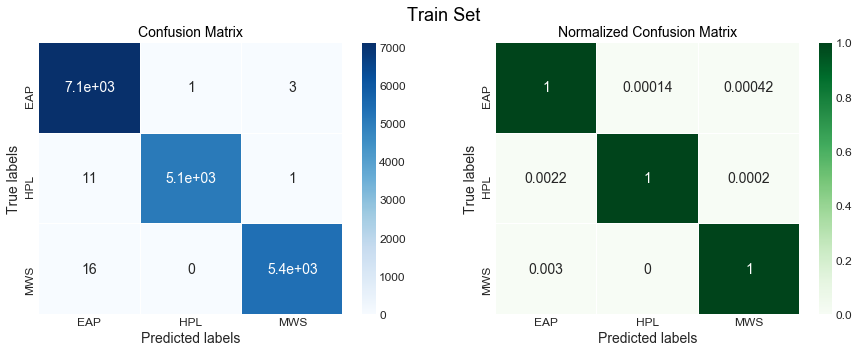

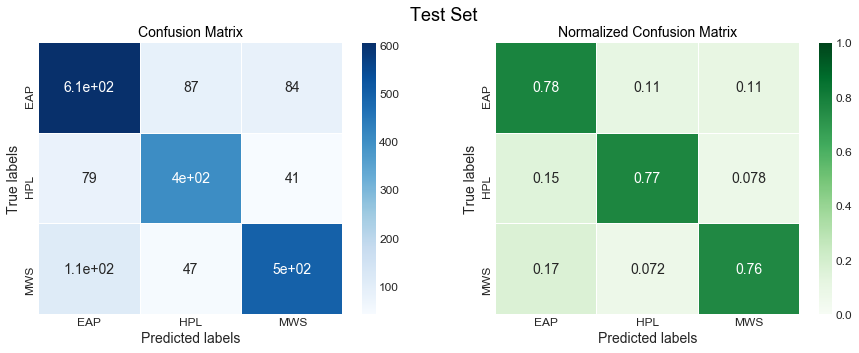

In [11]:
# Train set
y_pred = mlp.predict_proba(X_train_TFIDFvec)
Confusion_Matrix = confusion_matrix(y_train, y_pred.argmax(axis=1))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Train Set', fontsize = 18)
_ = sns.heatmap(Confusion_Matrix, annot=True, annot_kws={"size": 14}, cmap="Blues", ax = ax[0],
               linewidths = 0.2, cbar_kws={"shrink": 1})
_ = ax[0].set_xlabel('Predicted labels')
_ = ax[0].set_ylabel('True labels'); 
_ = ax[0].set_title('Confusion Matrix');
_ = ax[0].xaxis.set_ticklabels(Labels)
_ = ax[0].yaxis.set_ticklabels(Labels)

Confusion_Matrix = Confusion_Matrix.astype('float') / Confusion_Matrix.sum(axis=1)[:, np.newaxis]
_ = sns.heatmap(Confusion_Matrix, annot=True, annot_kws={"size": 14}, cmap="Greens", ax = ax[1],
               linewidths = 0.2, vmin=0, vmax=1, cbar_kws={"shrink": 1})
_ = ax[1].set_xlabel('Predicted labels')
_ = ax[1].set_ylabel('True labels'); 
_ = ax[1].set_title('Normalized Confusion Matrix');
_ = ax[1].xaxis.set_ticklabels(Labels)
_ = ax[1].yaxis.set_ticklabels(Labels)

# Test set
y_pred = mlp.predict_proba(X_test_TFIDFvec)
Confusion_Matrix = confusion_matrix(y_test, y_pred.argmax(axis=1))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Test Set', fontsize = 18)
_ = sns.heatmap(Confusion_Matrix, annot=True, annot_kws={"size": 14}, cmap="Blues", ax = ax[0],
                linewidths = 0.2, cbar_kws={"shrink": 1})
_ = ax[0].set_xlabel('Predicted labels')
_ = ax[0].set_ylabel('True labels'); 
_ = ax[0].set_title('Confusion Matrix');
_ = ax[0].xaxis.set_ticklabels(Labels)
_ = ax[0].yaxis.set_ticklabels(Labels)

Confusion_Matrix = Confusion_Matrix.astype('float') / Confusion_Matrix.sum(axis=1)[:, np.newaxis]
_ = sns.heatmap(Confusion_Matrix, annot=True, annot_kws={"size": 14}, cmap="Greens", ax = ax[1],
               linewidths = 0.2, vmin=0, vmax=1, cbar_kws={"shrink": 1})
_ = ax[1].set_xlabel('Predicted labels')
_ = ax[1].set_ylabel('True labels'); 
_ = ax[1].set_title('Normalized Confusion Matrix');
_ = ax[1].xaxis.set_ticklabels(Labels)
_ = ax[1].yaxis.set_ticklabels(Labels)

# Predictions

Using the model, we can now predict the text available from the **Pred** (Test) dataset.

In [12]:
X_pred = Tfidf_Vec.transform(Pred.Text.values)
y_pred = mlp.predict_proba(X_pred)

Predictions = pd.concat([Pred, pd.DataFrame(y_pred, columns = Labels)], axis =1)
Predictions

,ID,Text,EAP,HPL,MWS
0,id02310,"Still, as I urged our leaving Ireland with suc...",0.065377,0.005637,9.289857e-01
1,id24541,"If a fire wanted fanning, it could readily be ...",0.999953,0.000023,2.388220e-05
2,id00134,And when they had broken down the frail door t...,0.573151,0.424289,2.559992e-03
3,id27757,While I was thinking how I should possibly man...,0.042514,0.957363,1.228858e-04
4,id04081,I am not sure to what limit his knowledge may ...,0.999916,0.000077,7.220887e-06
...,...,...,...,...,...
8387,id11749,All this is now the fitter for my purpose.,0.363095,0.000011,6.368931e-01
8388,id10526,I fixed myself on a wide solitude.,0.000001,0.000192,9.998066e-01
8389,id13477,It is easily understood that what might improv...,0.924916,0.004081,7.100301e-02
8390,id13761,"Be this as it may, I now began to feel the ins...",0.986834,0.000005,1.316046e-02


***